In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import scipy.stats as stats
from scipy.stats import pearsonr, zscore
from itertools import combinations

File_Pathway_One = 'File_Path1.csv' #UPDATE {File1} file path
File_Pathway_Two ='File_Path2.csv'  #UPDATE {File2} file path

Compare_Col = 'Barcode1' #UPDATE with the column you want to compare that you have the read counts for. usually a barcode or barcode combination 

Name_reads_count_col_S1 = 'Read_Counts' #UPDATE with the name of the reads count column for {File_Pathway_One} 
Name_reads_count_col_S2 = 'Read_Coverage' #UPDATE with the name of the reads count column for {File_Pathway_Two}


Lib_Name = 'Library1' #UPDATE with your lib name that will be a part of all file names and graph titles 
File1 = 'Step1' #UPDATE short name for file one
File2 = 'Step2' #UPDATE short name for file two 

Fig_Format = 'jpg' #UPDATE fig format you want your graphs saved 

# Define your output directory
Output_Dir = f'graphs_{Lib_Name}' #UPDATE pathway to directory to save all your files and graphs 
os.makedirs(Output_Dir, exist_ok=True)



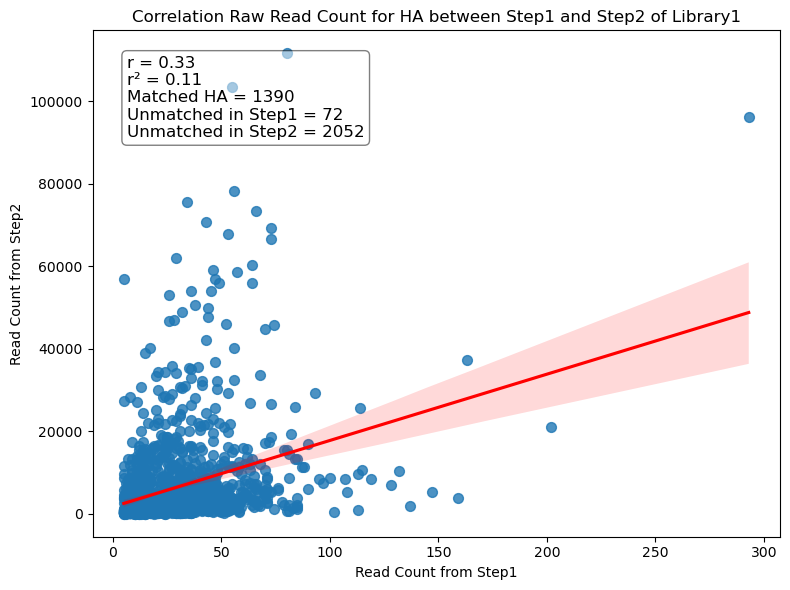

In [7]:
#raw counts correlation
# Load the CSV files
F1 = pd.read_csv(f'{File_Pathway_One}')
F2 = pd.read_csv(f'{File_Pathway_Two}')

# Ensure columns exist
assert f'{Compare_Col}' in F1.columns and f'{Name_reads_count_col_S1}' in F1.columns, f"{File1} missing required columns"
assert f'{Compare_Col}' in F2.columns and f'{Name_reads_count_col_S2}' in F2.columns, f"{File2} missing required columns"

# Rename read count columns for clarity
F1 = F1.rename(columns={f'{Name_reads_count_col_S1}': f'Read_Count_{File1}'})
F2 = F2.rename(columns={f'{Name_reads_count_col_S2}': f'Read_Count_{File2}'})

# Merge based on '{Compare_Col}'
merged = pd.merge(F1, F2, on=f'{Compare_Col}')

# Calculate correlation metrics
r, _ = pearsonr(merged[f'Read_Count_{File1}'], merged[f'Read_Count_{File2}'])
r2 = r ** 2

# Count matched and unmatched {Compare_Col}
unique_F1 = set(F1[f'{Compare_Col}'])
unique_F2 = set(F2[f'{Compare_Col}'])
matched_item = unique_F1 & unique_F2

matched_count = len(matched_item)
unmatched_F1 = len(unique_F1 - matched_item)
unmatched_F2 = len(unique_F2 - matched_item)

# Plot
plt.figure(figsize=(8, 6))
sns.regplot(x=f'Read_Count_{File1}', y=f'Read_Count_{File2}', data=merged,
            scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title(f'Correlation Raw Read Count for {Compare_Col} between {File1} and {File2} of {Lib_Name}')
plt.xlabel(f'Read Count from {File1}')
plt.ylabel(f'Read Count from {File2}')

# Annotate with stats
stats_text = (
    f"r = {r:.2f}\n"
    f"r² = {r2:.2f}\n"
    f"Matched {Compare_Col} = {matched_count}\n"
    f"Unmatched in {File1} = {unmatched_F1}\n"
    f"Unmatched in {File2} = {unmatched_F2}"
)
plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.tight_layout()

# Save the plo
plt.savefig(os.path.join(Output_Dir, f'Raw_Read_Counts_Correlation_{File1}_{File2}_{Lib_Name}_{Compare_Col}.{Fig_Format}'))

plt.show()


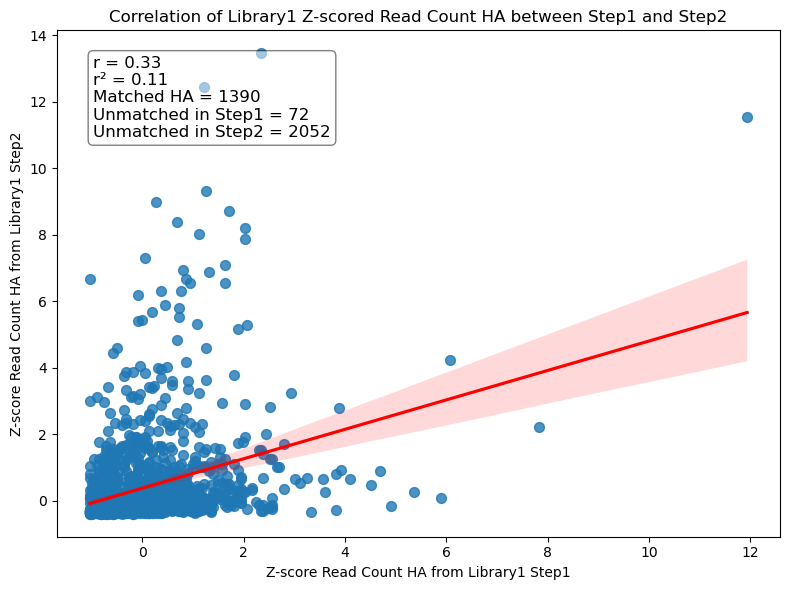

In [8]:
#z-scored within each file and then correlation
# Load the CSV files
F1a = pd.read_csv(f'{File_Pathway_One}')
F2a = pd.read_csv(f'{File_Pathway_Two}')


# Ensure required columns exist
assert f'{Compare_Col}'  in F1a.columns and f'{Name_reads_count_col_S1}' in F1a.columns, f"{File1} missing required columns"
assert f'{Compare_Col}' in F2a.columns and f'{Name_reads_count_col_S2}' in F2a.columns, f"{File2} missing required columns"

# Z-score the Cat_Counts within each dataset
F1a[f'Z_Read_Count_{File1}'] = zscore(F1a[f'{Name_reads_count_col_S1}'])
F2a[f'Z_Read_Count_{File2}'] = zscore(F2a[f'{Name_reads_count_col_S2}'])

# Merge on '{Compare_Col}'
merged_SSL4 = pd.merge(
    F1a[[f'{Compare_Col}', f'Z_Read_Count_{File1}']],
    F2a[[f'{Compare_Col}', f'Z_Read_Count_{File2}']],
    on=f'{Compare_Col}'
)

# Correlation metrics
r_SSL4, _ = pearsonr(merged_SSL4[f'Z_Read_Count_{File1}'], merged_SSL4[f'Z_Read_Count_{File2}'])
r2_SSL4 = r_SSL4 ** 2

# Count matched and unmatched {Compare_Col}
unique_F1a = set(F1a[f'{Compare_Col}'])
unique_F2a = set(F2a[f'{Compare_Col}'])
matching_items = unique_F1a & unique_F2a

matched_SSL4_count = len(matching_items)
unmatched_F1a = len(unique_F1a - matching_items)
unmatched_F2a = len(unique_F2a - matching_items)

# Plot
plt.figure(figsize=(8, 6))
sns.regplot(
    x=f'Z_Read_Count_{File1}',
    y=f'Z_Read_Count_{File2}',
    data=merged_SSL4,
    scatter_kws={'s': 50},
    line_kws={'color': 'red'}
)
plt.title(f'Correlation of {Lib_Name} Z-scored Read Count {Compare_Col} between {File1} and {File2}')
plt.xlabel(f'Z-score Read Count {Compare_Col} from {Lib_Name} {File1}')
plt.ylabel(f'Z-score Read Count {Compare_Col} from {Lib_Name} {File2}')

# Annotate with stats
stats_SSL4_text = (
    f"r = {r_SSL4:.2f}\n"
    f"r² = {r2_SSL4:.2f}\n"
    f"Matched {Compare_Col} = {matched_SSL4_count}\n"
    f"Unmatched in {File1} = {unmatched_F1a}\n"
    f"Unmatched in {File2} = {unmatched_F2a}"
)
plt.text(
    0.05, 0.95, stats_SSL4_text,
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
)

plt.tight_layout()
plt.savefig(os.path.join(Output_Dir, f'Z_Score_Read_Counts_Correlation_{File1}_{File2}_{Lib_Name}_{Compare_Col}.{Fig_Format}'))
plt.show()


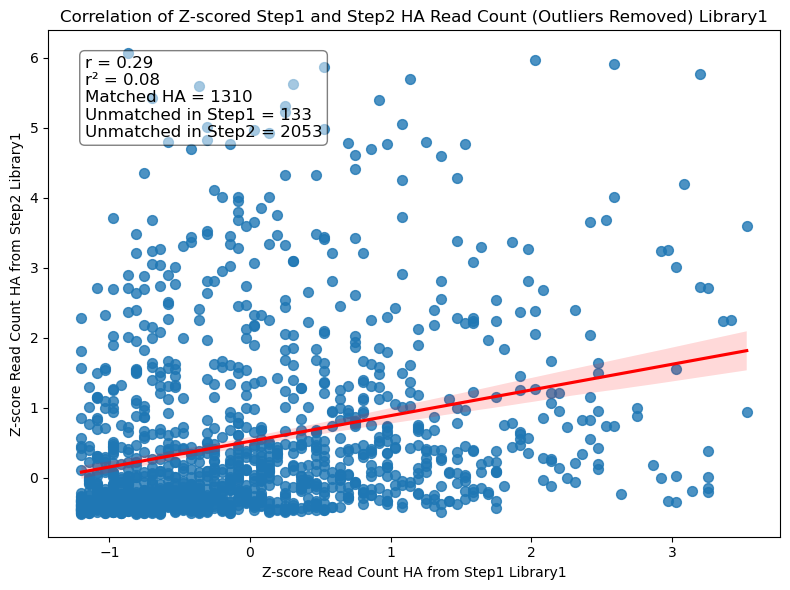

In [9]:
#z-scored within each file remove outliers and then re-z-score within each file and then correlation 
# Load the CSV files
F1a = pd.read_csv(f'{File_Pathway_One}')
F2a = pd.read_csv(f'{File_Pathway_Two}')

# Check required columns
# Ensure required columns exist
assert f'{Compare_Col}'  in F1a.columns and f'{Name_reads_count_col_S1}' in F1a.columns, f"{File1} missing required columns"
assert f'{Compare_Col}' in F2a.columns and f'{Name_reads_count_col_S2}' in F2a.columns, f"{File2} missing required columns"

# Z-score the Cat_Counts within each dataset
F1a[f'Z_Read_Count_{File1}'] = zscore(F1a[f'{Name_reads_count_col_S1}'])
F2a[f'Z_Read_Count_{File2}'] = zscore(F2a[f'{Name_reads_count_col_S2}'])

# Remove outliers (Z > 3 or Z < -3)
F1a_filtered = F1a[(F1a[f'Z_Read_Count_{File1}'].abs() <= 3)].copy()
F2a_filtered = F2a[(F2a[f'Z_Read_Count_{File2}'].abs() <= 3)].copy()

# Re-Z-score after filtering
F1a_filtered[f'Z_Read_Count_{File1}'] = zscore(F1a_filtered[f'{Name_reads_count_col_S1}'])
F2a_filtered[f'Z_Read_Count_{File2}'] = zscore(F2a_filtered[f'{Name_reads_count_col_S2}'])

# Merge on AD BCs
merged_SSL4 = pd.merge(
    F1a_filtered[[f'{Compare_Col}', f'Z_Read_Count_{File1}']],
    F2a_filtered[[f'{Compare_Col}', f'Z_Read_Count_{File2}']],
    on=f'{Compare_Col}'
)

# Correlation metrics
r_SSL4, _ = pearsonr(merged_SSL4[f'Z_Read_Count_{File1}'], merged_SSL4[f'Z_Read_Count_{File2}'])
r2_SSL4 = r_SSL4 ** 2

# Matched and unmatched AD BCs
unique_F1a = set(F1a_filtered[f'{Compare_Col}'])
unique_F2a = set(F2a_filtered[f'{Compare_Col}'])
matching_items = unique_F1a & unique_F2a

matched_SSL4_count = len(matching_items)
unmatched_F1a = len(unique_F1a - matching_items)
unmatched_F2a = len(unique_F2a - matching_items)

# Plot
plt.figure(figsize=(8, 6))
sns.regplot(
    x=f'Z_Read_Count_{File1}',
    y=f'Z_Read_Count_{File2}',
    data=merged_SSL4,
    scatter_kws={'s': 50},
    line_kws={'color': 'red'}
)
plt.title(f'Correlation of Z-scored {File1} and {File2} {Compare_Col} Read Count (Outliers Removed) {Lib_Name}')
plt.xlabel(f'Z-score Read Count {Compare_Col} from {File1} {Lib_Name}')
plt.ylabel(f'Z-score Read Count {Compare_Col} from {File2} {Lib_Name}')

# Annotate with stats
stats_SSL4_text = (
    f"r = {r_SSL4:.2f}\n"
    f"r² = {r2_SSL4:.2f}\n"
    f"Matched {Compare_Col} = {matched_SSL4_count}\n"
    f"Unmatched in {File1} = {unmatched_F1a}\n"
    f"Unmatched in {File2} = {unmatched_F2a}"
)
plt.text(
    0.05, 0.95, stats_SSL4_text,
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
)

plt.tight_layout()
plt.savefig(os.path.join(Output_Dir, f'Zscore_Read_Count_Correlation_{Compare_Col}_{Lib_Name}_outliers_removed.{Fig_Format}'))
plt.show()


In [10]:
#identify unmatched items from the correlations and export into a file that you can further analyze
# Identify unmatched AD BCs
unmatched_F1b = unique_F1a - matching_items
unmatched_F2b = unique_F2a - matching_items

# Filter rows with unmatched AD BCs
unmatched_F1_df = F1a[F1a[f'{Compare_Col}'].isin(unmatched_F1b)].copy()
unmatched_F2_df = F2a[F2a[f'{Compare_Col}'].isin(unmatched_F2b)].copy()

# Combine both unmatched sets into one DataFrame with source labels
unmatched_F1_df['Source'] = f'{File1}'
unmatched_F2_df['Source'] = f'{File2}'
unmatched_combined_df = pd.concat([unmatched_F1_df, unmatched_F2_df], ignore_index=True)

# Export to CSV and Excel
a = f"Unmatched_{Compare_Col}_{Lib_Name}.csv"
b = f'Unmatched_{Compare_Col}_{Lib_Name}.xlsx'
unmatched_combined_df.to_csv(os.path.join(Output_Dir, a), index=False)
unmatched_combined_df.to_excel(os.path.join(Output_Dir, b), index=False)


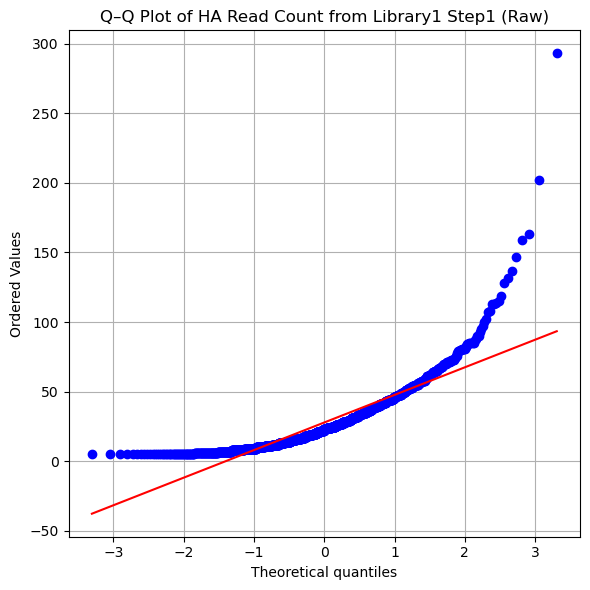

Step1 Raw Shapiro-Wilk p-value: 0.0000
Step1 Log-transformed Shapiro-Wilk p-value: 0.0000


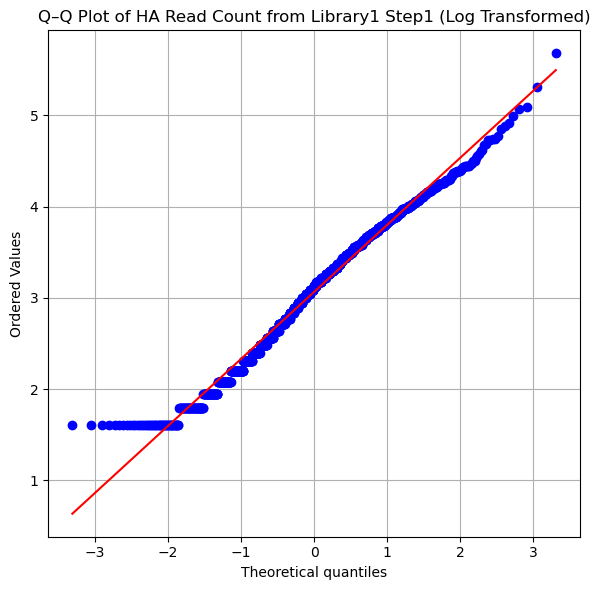

Step1 Box-Cox-transformed Shapiro-Wilk p-value: 0.0000


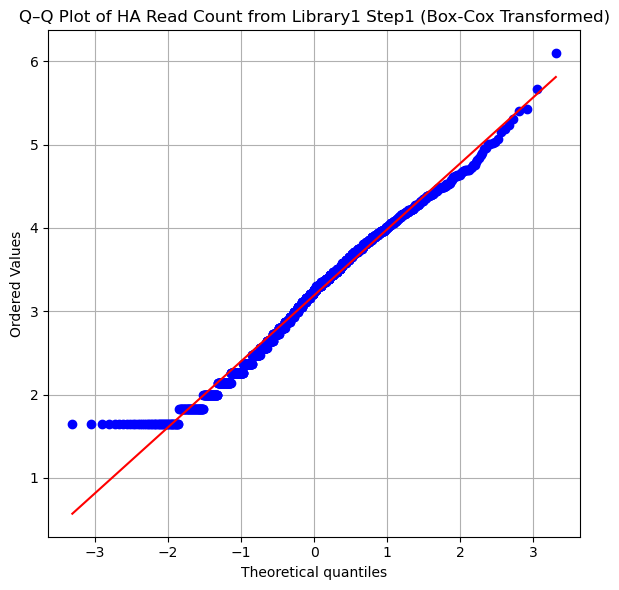

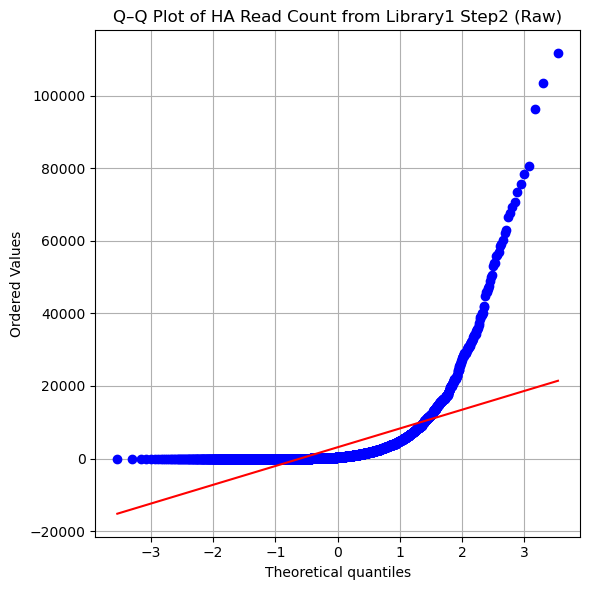

Step2 Raw Shapiro-Wilk p-value: 0.0000
Step2 Log-transformed Shapiro-Wilk p-value: 0.0000


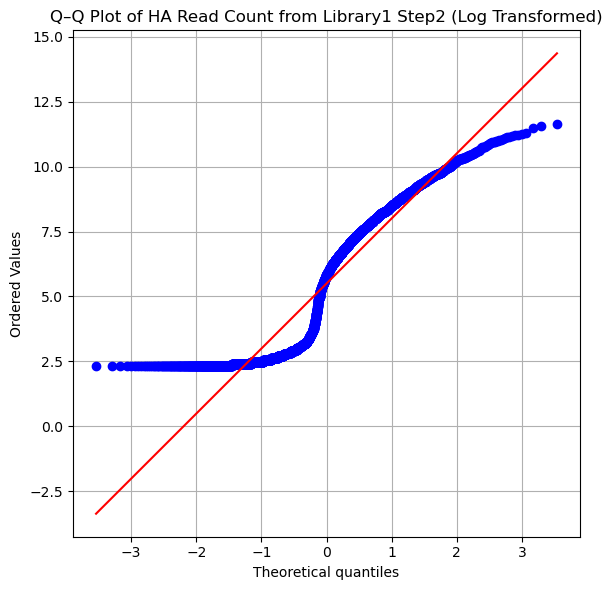

Step2 Box-Cox-transformed Shapiro-Wilk p-value: 0.0000


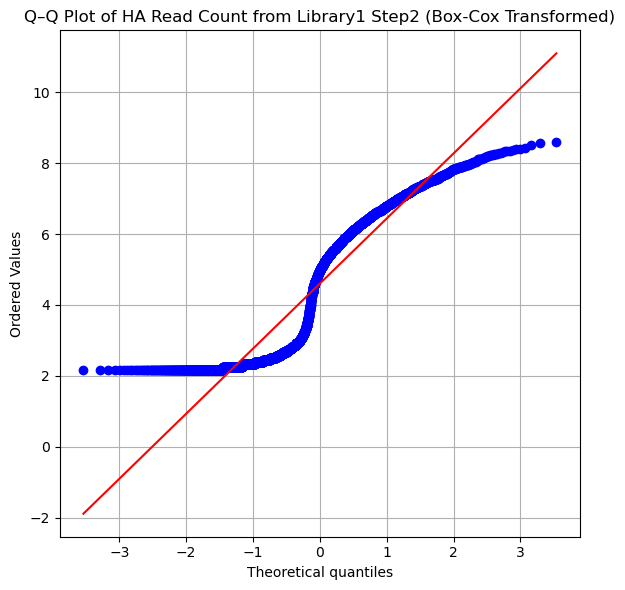

In [11]:
#Q-Q plots for checking skewness
def process_ssl4_qq_plot(file_path, label, col):
    # Load data
    df = pd.read_csv(file_path)

    # Raw Q–Q plot
    plt.figure(figsize=(6, 6))
    stats.probplot(df[col], dist="norm", plot=plt)
    plt.title(f"Q–Q Plot of {Compare_Col} Read Count from {Lib_Name} {label} (Raw)")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(Output_Dir, f"QQ_Plot_{Compare_Col}_{label}_Raw.{Fig_Format}"))
    plt.show()

    # Shapiro-Wilk test for normality
    stat, p = stats.shapiro(df[col])
    print(f"{label} Raw Shapiro-Wilk p-value: {p:.4f}")

    # If not normal, try log transform
    if p < 0.05:
        df_log = df[df[col] > 0].copy()  # log only works on positive values
        df_log['Read_Count_Log'] = np.log(df_log[col])

        stat_log, p_log = stats.shapiro(df_log['Read_Count_Log'])
        print(f"{label} Log-transformed Shapiro-Wilk p-value: {p_log:.4f}")

        plt.figure(figsize=(6, 6))
        stats.probplot(df_log['Read_Count_Log'], dist="norm", plot=plt)
        plt.title(f"Q–Q Plot of {Compare_Col} Read Count from {Lib_Name} {label} (Log Transformed)")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(Output_Dir, f"QQ_Plot_{Compare_Col}_{Lib_Name}_{label}_Log.{Fig_Format}"))
        plt.show()

        # If still not normal, try Box-Cox
        if p_log < 0.05:
            df_boxcox = df_log.copy()
            df_boxcox['Read_Count_BoxCox'], _ = stats.boxcox(df_boxcox[col])

            stat_boxcox, p_boxcox = stats.shapiro(df_boxcox['Read_Count_BoxCox'])
            print(f"{label} Box-Cox-transformed Shapiro-Wilk p-value: {p_boxcox:.4f}")

            plt.figure(figsize=(6, 6))
            stats.probplot(df_boxcox['Read_Count_BoxCox'], dist="norm", plot=plt)
            plt.title(f"Q–Q Plot of {Compare_Col} Read Count from {Lib_Name} {label} (Box-Cox Transformed)")
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(os.path.join(Output_Dir, f"QQ_Plot_{Compare_Col}_{Lib_Name}_{label}_BoxCox.{Fig_Format}"))
            plt.show()

# Run for both files 
process_ssl4_qq_plot(f'{File_Pathway_One}', f'{File1}', f'{Name_reads_count_col_S1}')
process_ssl4_qq_plot(f'{File_Pathway_Two}', f'{File2}', f'{Name_reads_count_col_S2}')




In [19]:
# Calculate skewness coeifficent 
skew_value = round(F1a[f'{Name_reads_count_col_S1}'].skew(),2)
print(f"Skewness of {File1} {Compare_Col} Read Counts:", skew_value)

# Calculate skewness
skew_value2 = round(F2a[f'{Name_reads_count_col_S2}'].skew(),2)
print(f"Skewness of {File2} {Compare_Col} Read Counts:", skew_value2)

Skewness of Step1 HA Read Counts: 2.89
Skewness of Step2 HA Read Counts: 5.7


In [20]:
# Create a summary table of row counts
row_counts = pd.DataFrame({
    'Dataset': [f'{File1}', f'{File2}'],
    'Number of Rows': [
        len(F1a),
        len(F2a),
    ]
})

# Display the table
print("Number of rows in each dataset:")
display(row_counts)


Number of rows in each dataset:


,Dataset,Number of Rows
0,Step1,1467
1,Step2,3442


In [ ]:
#below code will filter the dfs to be the top specific number of % usually top 10 or top 25 are common 

In [23]:
#Compare percent similarity of the two files based on the top 10% and top 20% Read Count
# Sort by Cat_Count descending
datasets = {
    f'{File1}': F1a.sort_values(by=f'{Name_reads_count_col_S1}', ascending=False),
    f'{File2}': F2a.sort_values(by=f'{Name_reads_count_col_S2}', ascending=False),
}

# Function to get top N% AD BCs
def get_top_percent(df, percent):
    n = max(1, int(len(df) * percent / 100))
    return set(df.head(n)[f'{Compare_Col}']), n

# Build top 10% and 20% sets
top10_sets = {}
top20_sets = {}
top10_sizes = {}
top20_sizes = {}

for name, df in datasets.items():
    top10_sets[name], top10_sizes[name] = get_top_percent(df, 10)
    top20_sets[name], top20_sizes[name] = get_top_percent(df, 20)

# Compare all combinations for top 10%
results_10 = []
for combo in combinations(top10_sets.keys(), 2):
    set1, set2 = top10_sets[combo[0]], top10_sets[combo[1]]
    intersection = set1 & set2
    percent_similar = len(intersection) / min(top10_sizes[combo[0]], top10_sizes[combo[1]]) * 100
    results_10.append({
        'Comparison': f"{combo[0]} vs {combo[1]}",
        f'Top 10% Shared {Compare_Col}': len(intersection),
        'Top 10% Percent Similarity': f"{percent_similar:.1f}%"
    })

# Compare all combinations for top 20%
results_20 = []
for combo in combinations(top20_sets.keys(), 2):
    set1, set2 = top20_sets[combo[0]], top20_sets[combo[1]]
    intersection = set1 & set2
    percent_similar = len(intersection) / min(top20_sizes[combo[0]], top20_sizes[combo[1]]) * 100
    results_20.append({
        'Comparison': f"{combo[0]} vs {combo[1]}",
        f'Top 20% Shared {Compare_Col}': len(intersection),
        'Top 20% Percent Similarity': f"{percent_similar:.1f}%"
    })

# Merge results into one table
similarity_df = pd.DataFrame(results_10).merge(
    pd.DataFrame(results_20),
    on='Comparison'
)

# Display the table
print(f"Top 10% and 20% {Compare_Col} similarity across datasets:")
display(similarity_df)

Top 10% and 20% HA similarity across datasets:


,Comparison,Top 10% Shared HA,Top 10% Percent Similarity,Top 20% Shared HA,Top 20% Percent Similarity
0,Step1 vs Step2,61,41.8%,189,64.5%


In [26]:
#create files that filter for the top 10% highest read counts

# Function to get top 10% and export
def export_top10(df, name, col):
    top10_df = df.sort_values(by=col, ascending=False).head(int(len(df) * 0.10))
    top10_df.to_csv(os.path.join(Output_Dir, f'{name}_top10.csv'), index=False)
    top10_df.to_excel(os.path.join(Output_Dir, f'{name}_top10.xlsx'), index=False)
    return top10_df

# Process and export each dataset
F1a_top10 = export_top10(F1a, f'{File1}',f'{Name_reads_count_col_S1}')
F2a_top10 = export_top10(F2a, f'{File1}',f'{Name_reads_count_col_S2}')

In [28]:
#compare the order of the top 10% (is #1 in file 1 #1 in file 2?)
def compare_ranks(df1, df2, name1="DF1", name2="DF2"):
    """
    Compare rankings of Compare_Col column 
    If an item is missing in one df, its rank = 0.
    """
    # Rank each dataframe (start=1 for largest, keep order after sorting)
    df1_ranked = (
        df1.sort_values(by=f"{Name_reads_count_col_S1}", ascending=False)
           .reset_index(drop=True)
           .reset_index()
    )
    df1_ranked.rename(columns={"index": f"{name1}_Rank"}, inplace=True)
    df1_ranked[f"{name1}_Rank"] += 1  # ranks start at 1

    df2_ranked = (
        df2.sort_values(by=f"{Name_reads_count_col_S2}", ascending=False)
           .reset_index(drop=True)
           .reset_index()
    )
    df2_ranked.rename(columns={"index": f"{name2}_Rank"}, inplace=True)
    df2_ranked[f"{name2}_Rank"] += 1

    # Merge on AD BCs, fill missing with 0
    merged = pd.merge(
        df1_ranked[[f"{Compare_Col}", f"{name1}_Rank"]],
        df2_ranked[[f"{Compare_Col}", f"{name2}_Rank"]],
        on=f"{Compare_Col}",
        how="outer"
    ).fillna(0)

    # Convert ranks to int
    merged[f"{name1}_Rank"] = merged[f"{name1}_Rank"].astype(int)
    merged[f"{name2}_Rank"] = merged[f"{name2}_Rank"].astype(int)

    #makes it so you see how the top of each comparares in the print out
    merged["Best_Rank"] = merged[[f"{name1}_Rank", f"{name2}_Rank"]].replace(0, 1e9).min(axis=1)

    return merged.sort_values(by="Best_Rank").drop(columns="Best_Rank")

# Example usage:
comparison_F1_F2 = compare_ranks(F1a_top10, F2a_top10, f"Top10_{File1}", f"Top10_{File2}")

# Display one comparison
comparison_F1_F2.head(20)

,HA,Top10_Step1_Rank,Top10_Step2_Rank
0,CACCGATTG-CCATAA,1,3
39,CAACAGTGC-TTAGGC,40,1
1,CCATTAACG-GTCAGC,2,110
138,CAATCTCTC-ATGATC,139,2
2,CCATCGGTT-GTACAA,3,40
3,CCGCAGTTA-AGTAAA,4,0
146,CAATCTCTC-TCATAT,0,4
4,CCGGAGAAT-ATTATT,5,0
128,CAAGACCTA-ACGATG,129,5
5,CCGCAGTTA-CCGACA,6,0


In [ ]:
#Below makes the same types of correlation and skew but now using the top 10% versions of the files


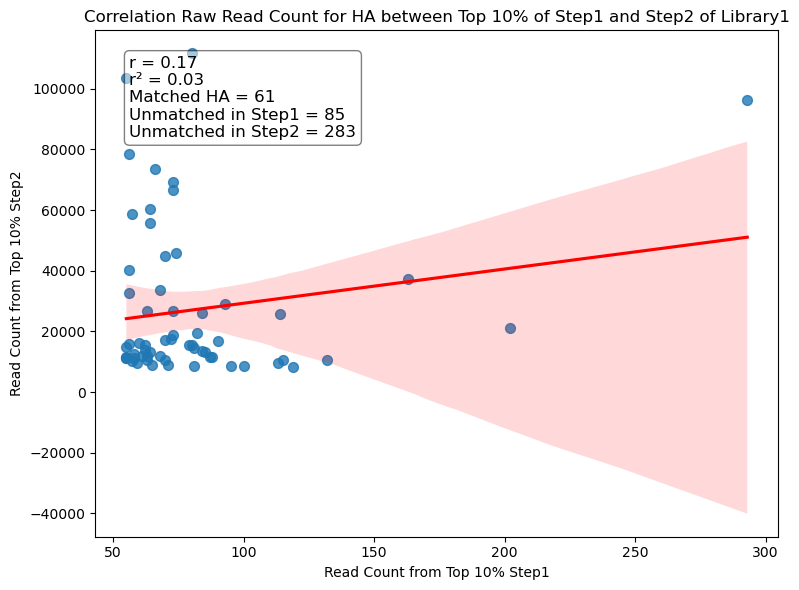

In [30]:
#raw counts correlation
# Load the CSV files

# Ensure columns exist
assert f'{Compare_Col}' in F1a_top10.columns and f'{Name_reads_count_col_S1}' in F1a_top10.columns, f"{File1} missing required columns"
assert f'{Compare_Col}' in F2a_top10.columns and f'{Name_reads_count_col_S2}' in F2a_top10.columns, f"{File2} missing required columns"

# Rename read count columns for clarity
F1a_top10 = F1a_top10.rename(columns={f'{Name_reads_count_col_S1}': f'Read_Count_{File1}'})
F2a_top10 = F2a_top10.rename(columns={f'{Name_reads_count_col_S2}': f'Read_Count_{File2}'})

# Merge based on '{Compare_Col}'
merged = pd.merge(F1a_top10, F2a_top10, on=f'{Compare_Col}')

# Calculate correlation metrics
r, _ = pearsonr(merged[f'Read_Count_{File1}'], merged[f'Read_Count_{File2}'])
r2 = r ** 2

# Count matched and unmatched {Compare_Col}
unique_F1 = set(F1a_top10[f'{Compare_Col}'])
unique_F2 = set(F2a_top10[f'{Compare_Col}'])
matched_item = unique_F1 & unique_F2

matched_count = len(matched_item)
unmatched_F1 = len(unique_F1 - matched_item)
unmatched_F2 = len(unique_F2 - matched_item)

# Plot
plt.figure(figsize=(8, 6))
sns.regplot(x=f'Read_Count_{File1}', y=f'Read_Count_{File2}', data=merged,
            scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title(f'Correlation Raw Read Count for {Compare_Col} between Top 10% of {File1} and {File2} of {Lib_Name}')
plt.xlabel(f'Read Count from Top 10% {File1}')
plt.ylabel(f'Read Count from Top 10% {File2}')

# Annotate with stats
stats_text = (
    f"r = {r:.2f}\n"
    f"r² = {r2:.2f}\n"
    f"Matched {Compare_Col} = {matched_count}\n"
    f"Unmatched in {File1} = {unmatched_F1}\n"
    f"Unmatched in {File2} = {unmatched_F2}"
)
plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.tight_layout()

# Save the plo
plt.savefig(os.path.join(Output_Dir, f'Top10_Raw_Read_Counts_Correlation_{File1}_{File2}_{Lib_Name}_{Compare_Col}.{Fig_Format}'))

plt.show()